In [5]:
from quantrocket.license import set_license
set_license("c1121ec0-ded8-11ee-9ca3-4734c0f2cd98")

{'licensekey': 'c112........cd98', 'software_license': {}}

In [1]:
from quantrocket.history import collect_history
collect_history("free-usstock-1d-bundle")

{'status': 'the historical data will be collected asynchronously'}

In [2]:
from quantrocket.zipline import create_usstock_bundle

create_usstock_bundle("free-usstock-1d-bundle", data_frequency="daily", free=True)

{'status': 'success', 'msg': 'successfully created usstock-free-1d bundle'}

In [2]:
from quantrocket.zipline import ingest_bundle

ingest_bundle("free-usstock-1d-bundle")

{'status': 'the data will be ingested asynchronously'}

In [ ]:
!quantrocket flightlog stream

2024-03-10 13:08:51 quantrocket.zipline: INFO [usstock-free-1d] Ingesting daily bars for usstock-free-1d bundle


In [1]:
from quantrocket.zipline import list_bundles
list_bundles()

{'free-usstock-1d-bundle': True, 'usstock-free-1d': False}

Date
2023-01-04    0.010316
2023-01-05   -0.010608
2023-01-06    0.036799
2023-01-09    0.004088
2023-01-10    0.004450
                ...   
2023-12-22   -0.005548
2023-12-26   -0.002841
2023-12-27    0.000518
2023-12-28    0.002226
2023-12-29   -0.005424
Name: FIBBG000B9XRY4, Length: 249, dtype: float64


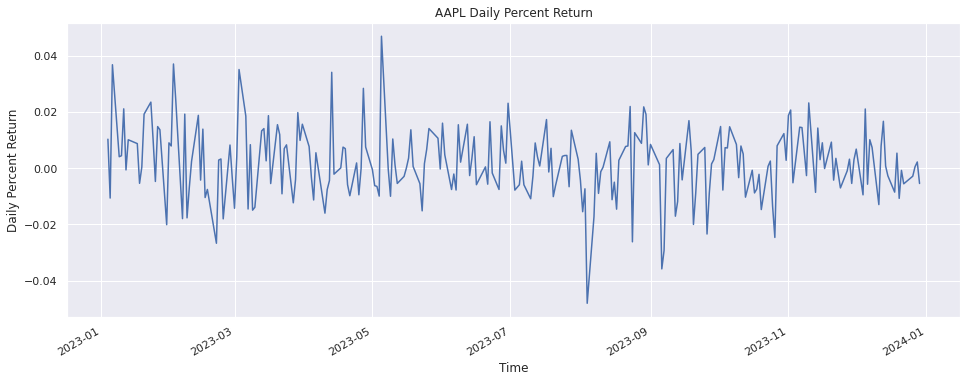

In [2]:
from quantrocket.master import get_securities
from quantrocket import get_prices
import matplotlib.pyplot as plt
import statsmodels.api as sm

start_date = '2023-01-01'
end_date = '2023-12-31'

# Retrieve security information for AAPL
securities = get_securities(symbols=['AAPL'], vendors='usstock')
AAPL = securities[securities.Symbol=='AAPL'].index[0]

# Retrieve daily close prices for AAPL
R = get_prices('free-usstock-1d-bundle', sids=AAPL, data_frequency='daily', fields='Close', start_date=start_date, end_date=end_date)
R = R.loc['Close'][AAPL].pct_change()[1:]
print(R)

# Plot the daily percent return for AAPL
R.plot()
plt.xlabel('Time')
plt.ylabel('Daily Percent Return')
plt.title('AAPL Daily Percent Return')
plt.show()

In [6]:
import numpy as np
import pandas as pd

# state classification
def classify_state(return_value):
    if return_value >= 0.01:
        return 1  # Bull state
    elif return_value > -0.01:
        return 0  # Flat state
    else:
        return -1  # Bear state

# portfolio value and check if buy order placed
def calculate_portfolio_value_and_buy_order(previous_state, current_state, portfolio_value):
    if current_state == 1 and previous_state == 0:
        return portfolio_value + 1, True  # True if buy order placed
    elif current_state == -1 and previous_state == 0:
        return portfolio_value - 1, True  # True if buy order placed
    else:
        return portfolio_value, False  # False if no buy order placed

# Initialize variables
previous_state = 0
portfolio_value = 0
transition_matrix = pd.DataFrame(index=[-1, 0, 1], columns=[-1, 0, 1]).fillna(0)
optimal_buy_indices = []

# streaming of data 
close_prices = R.tolist()
print(close_prices)

for i in range(1, len(close_prices)):
    # return percentage
    if close_prices[i-1] != 0:  
        return_value = (close_prices[i] - close_prices[i-1]) / close_prices[i-1]
    else:
        return_value = 0  

    # Classify state
    current_state = classify_state(return_value)

    # Calculate portfolio value and check if buy order placed
    portfolio_value, buy_order_placed = calculate_portfolio_value_and_buy_order(previous_state, current_state, portfolio_value)
    
    # Update transition matrix
    transition_matrix.loc[previous_state, current_state] += 1

    # Record optimal buy index if buy order placed
    if buy_order_placed:
        optimal_buy_indices.append(i)

    # Update previous state for next iteration
    previous_state = current_state

# Normalize transition matrix
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

print("Portfolio value at the end:", portfolio_value)
print("Number of buy orders placed:", len(optimal_buy_indices))
print("Optimal buy indices:", optimal_buy_indices)
print("Transition matrix:")
print(transition_matrix)

[0.010315577889447258, -0.010608158652851363, 0.036798713050472553, 0.004088440651667913, 0.0044503851592017085, 0.021114897348522677, -0.0006026456142463887, 0.010123013839056894, 0.008753012812381167, -0.005370458042371906, 0.0004462359993455678, 0.019224193044797167, 0.023500408449060428, 0.010062283539757466, -0.004705865752303584, 0.014808146252596188, 0.01368398994132436, -0.02008007221659458, 0.009022186280369882, 0.007903099910794076, 0.037062134391724566, 0.02439626088463953, -0.017924902857961, 0.019239563381868496, -0.017647441316080315, -0.00691704837300422, 0.002459491705047556, 0.018803191489361826, -0.004222465867857128, 0.013900813338489026, -0.010426497394991685, -0.007544630900979121, -0.026682638514091694, 0.002894238571814922, 0.0032904496048762333, -0.018004516250436864, 0.008246815907799965, -0.0034482290492934276, -0.014242510932199748, 0.004132031536106862, 0.03508784002312115, 0.018541417364712265, -0.014496537409682264, 0.008371526214003833, -0.014909492157738